# 🔬 Raw Data Analysis: Event Detection & Scoring Deep Dive

**Author:** Reza Mirzaeifard
**Date:** December 2025

---

## Overview

This notebook explores the **raw sensor data** from UAH-DriveSet to understand:
1. **How events are detected** (turning, braking, acceleration, lane changes)
2. **How driving behavior is scored** (the DriveSafe algorithm)
3. **Advanced analysis techniques** using time-series data

### Data Sources
The UAH-DriveSet provides 9 files per trip:
- **RAW_GPS.txt** - GPS data at 1Hz (speed, coordinates, course)
- **RAW_ACCELEROMETERS.txt** - 3-axis accelerometer data (X, Y, Z)
- **SEMANTIC_ONLINE.txt** - Real-time behavior scores and ratios

### Key Insights from Dataset
- Events are detected from **accelerometer thresholds** and **GPS course changes**
- Scores are computed heuristically based on event frequency and intensity
- Behaviors emerge from the **combination** of multiple event types

---


In [1]:
# Clear stale imports
import sys
for mod in list(sys.modules.keys()):
    if mod.startswith('src'):
        del sys.modules[mod]


In [2]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut

# Import all raw data functions from src
from src.data import (
    get_all_trips,
    load_raw_gps,
    load_raw_accelerometer,
    load_inertial_events,
    load_semantic_online,
    extract_raw_features,
    build_raw_dataset,
    compute_acceleration_magnitude,
    summarize_events,
)
from src.visualization import setup_style
from src.utils import print_success, print_header

setup_style()
print_success("Setup complete")


✅ Setup complete


## 1. Understanding the Raw Data Structure

Let's load and examine the raw sensor data from one trip to understand the data structure.


In [3]:
data_dir = project_root / 'data' / 'UAH-DRIVESET-v1'

# Get all trips using src function
trips = get_all_trips(data_dir)
print(f"📊 Found {len(trips)} trips")
print(f"   Drivers: {sorted(set(t['driver'] for t in trips))}")
print(f"   Behaviors: {sorted(set(t['behavior'] for t in trips))}")


📊 Found 40 trips
   Drivers: ['D1', 'D2', 'D3', 'D4', 'D5', 'D6']
   Behaviors: ['AGGRESSIVE', 'DROWSY', 'NORMAL']


## 2. Loading Raw Sensor Data

We use functions from `src.data.raw_loader` to load the raw sensor files.


In [4]:
# Load sample trip (aggressive driving for clear event examples)
sample_trip = [t for t in trips if t['behavior'] == 'AGGRESSIVE'][0]
print(f"Loading: {sample_trip['driver']} - {sample_trip['behavior']} - {sample_trip['road_type']}")

# Load using src functions
gps = load_raw_gps(sample_trip['path'])
acc = load_raw_accelerometer(sample_trip['path'])
events = load_inertial_events(sample_trip['path'])

print(f"GPS samples: {len(gps) if gps is not None else 0}")
print(f"Accelerometer samples: {len(acc) if acc is not None else 0}")
print(f"Detected events: {len(events) if events is not None else 0}")


Loading: D1 - AGGRESSIVE - MOTORWAY
GPS samples: 737
Accelerometer samples: 7287
Detected events: 11


## 3. How Events Are Detected

The DriveSafe algorithm detects events using:
1. **Accelerometer data** → Braking, Acceleration, Turning
2. **GPS course changes** → Lane changes, Weaving
3. **Speed data** → Overspeeding

### 3.1 Accelerometer-Based Event Detection


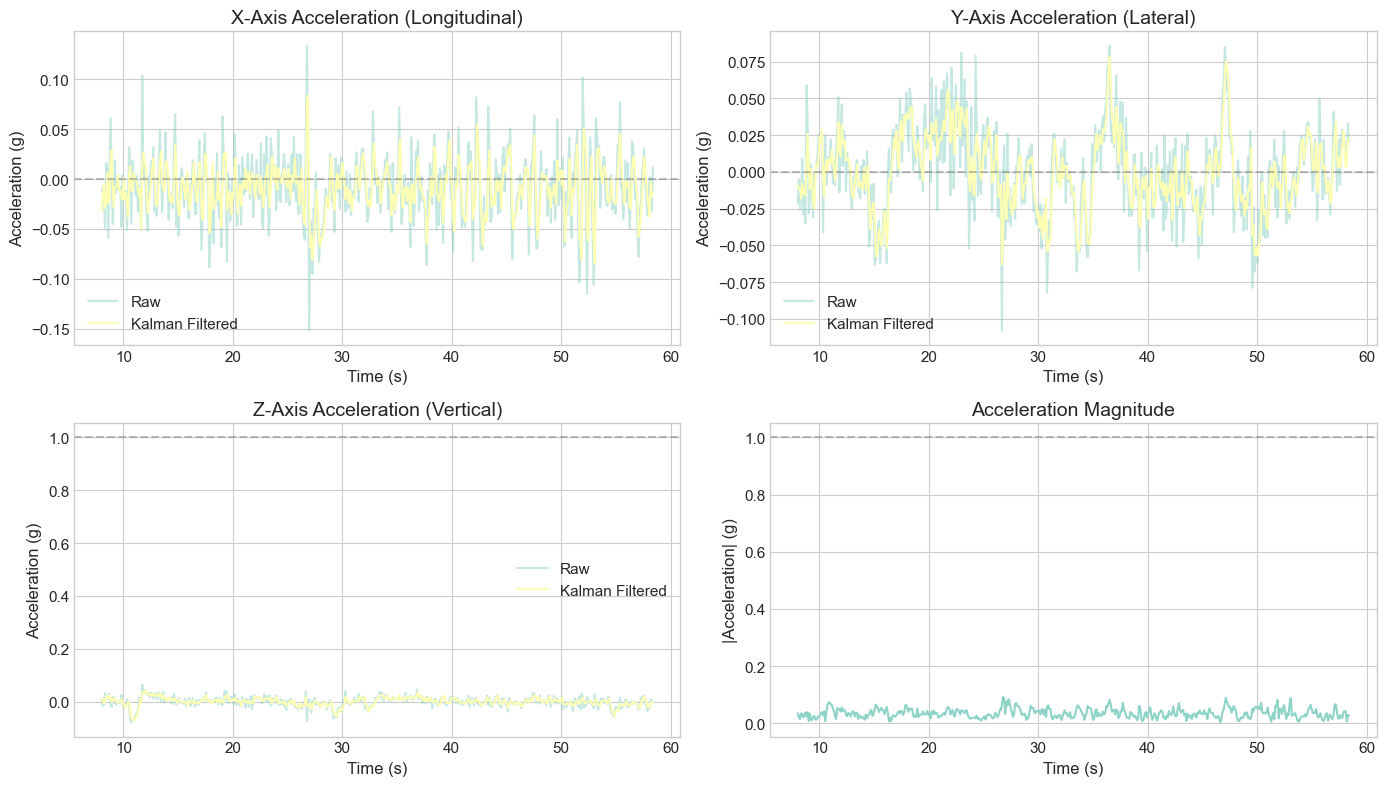

In [5]:
if acc is not None:
    # Calculate acceleration magnitude using src function
    acc['acc_magnitude'] = compute_acceleration_magnitude(
        acc['acc_x_kf'].values,
        acc['acc_y_kf'].values,
        acc['acc_z_kf'].values
    )

    # Kalman filtered data is smoother - compare raw vs filtered
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    # Plot X acceleration
    ax = axes[0, 0]
    ax.plot(acc['timestamp'][:500], acc['acc_x'][:500], alpha=0.5, label='Raw')
    ax.plot(acc['timestamp'][:500], acc['acc_x_kf'][:500], label='Kalman Filtered')
    ax.set_title('X-Axis Acceleration (Longitudinal)')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Acceleration (g)')
    ax.legend()
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

    # Plot Y acceleration
    ax = axes[0, 1]
    ax.plot(acc['timestamp'][:500], acc['acc_y'][:500], alpha=0.5, label='Raw')
    ax.plot(acc['timestamp'][:500], acc['acc_y_kf'][:500], label='Kalman Filtered')
    ax.set_title('Y-Axis Acceleration (Lateral)')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Acceleration (g)')
    ax.legend()
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

    # Plot Z acceleration
    ax = axes[1, 0]
    ax.plot(acc['timestamp'][:500], acc['acc_z'][:500], alpha=0.5, label='Raw')
    ax.plot(acc['timestamp'][:500], acc['acc_z_kf'][:500], label='Kalman Filtered')
    ax.set_title('Z-Axis Acceleration (Vertical)')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Acceleration (g)')
    ax.legend()
    ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5, label='Gravity')

    # Plot magnitude
    ax = axes[1, 1]
    ax.plot(acc['timestamp'][:500], acc['acc_magnitude'][:500])
    ax.set_title('Acceleration Magnitude')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('|Acceleration| (g)')
    ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5, label='Gravity baseline')

    plt.tight_layout()
    plt.savefig(project_root / 'results' / 'figures' / 'raw_accelerometer_data.png', dpi=300, bbox_inches='tight')
    plt.show()


### 3.2 Understanding Event Types

**Key Insight:** The phone orientation affects which axis measures what:
- **X-axis (Longitudinal)**: Forward/backward → **Braking** (negative) & **Acceleration** (positive)
- **Y-axis (Lateral)**: Left/right → **Turning**
- **Z-axis (Vertical)**: Up/down → Road bumps, inclination



📊 EVENT DETECTION SUMMARY

Event counts:
  braking: 8
  turning: 3

Event severity distribution:
level_name  low  medium
event_name             
braking       5       3
turning       2       1


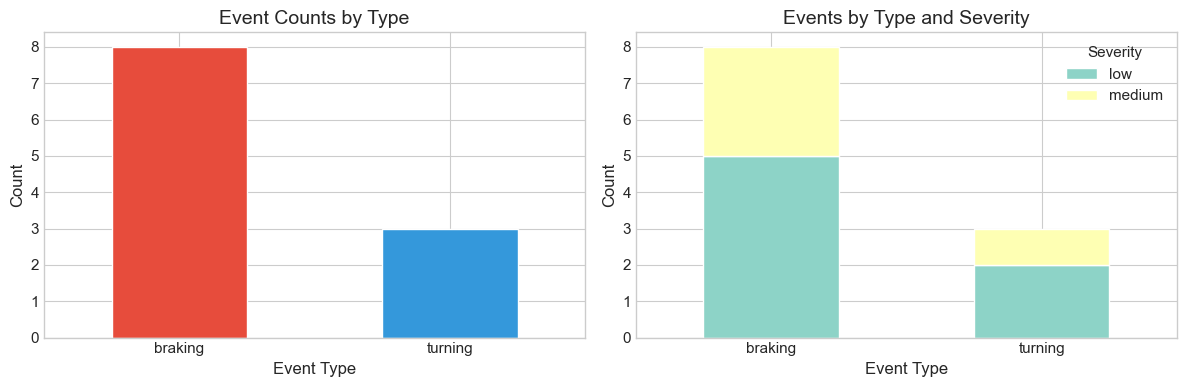

In [6]:
if events is not None:
    print_header("EVENT DETECTION SUMMARY", "📊")

    # Count events by type
    event_counts = events['event_name'].value_counts()
    print(f"\nEvent counts:")
    for event, count in event_counts.items():
        print(f"  {event}: {count}")

    # Count by severity
    print(f"\nEvent severity distribution:")
    severity_dist = events.groupby(['event_name', 'level_name']).size().unstack(fill_value=0)
    print(severity_dist)

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    ax = axes[0]
    event_counts.plot(kind='bar', ax=ax, color=['#e74c3c', '#3498db', '#2ecc71'])
    ax.set_title('Event Counts by Type')
    ax.set_xlabel('Event Type')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=0)

    ax = axes[1]
    severity_dist.plot(kind='bar', ax=ax, stacked=True)
    ax.set_title('Events by Type and Severity')
    ax.set_xlabel('Event Type')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=0)
    ax.legend(title='Severity')

    plt.tight_layout()
    plt.savefig(project_root / 'results' / 'figures' / 'event_detection_summary.png', dpi=300, bbox_inches='tight')
    plt.show()


## 4. How Scoring Works

The DriveSafe algorithm computes scores (0-100) for each behavior dimension:
- **100** = Perfect (no events)
- **0** = Worst (many high-severity events)

The scoring formula (simplified):
```
score = 100 - penalty_factor * weighted_event_count
```

Where:
- `penalty_factor` depends on event severity (high > medium > low)
- Events are weighted by their type and road context


Semantic data: 732 rows


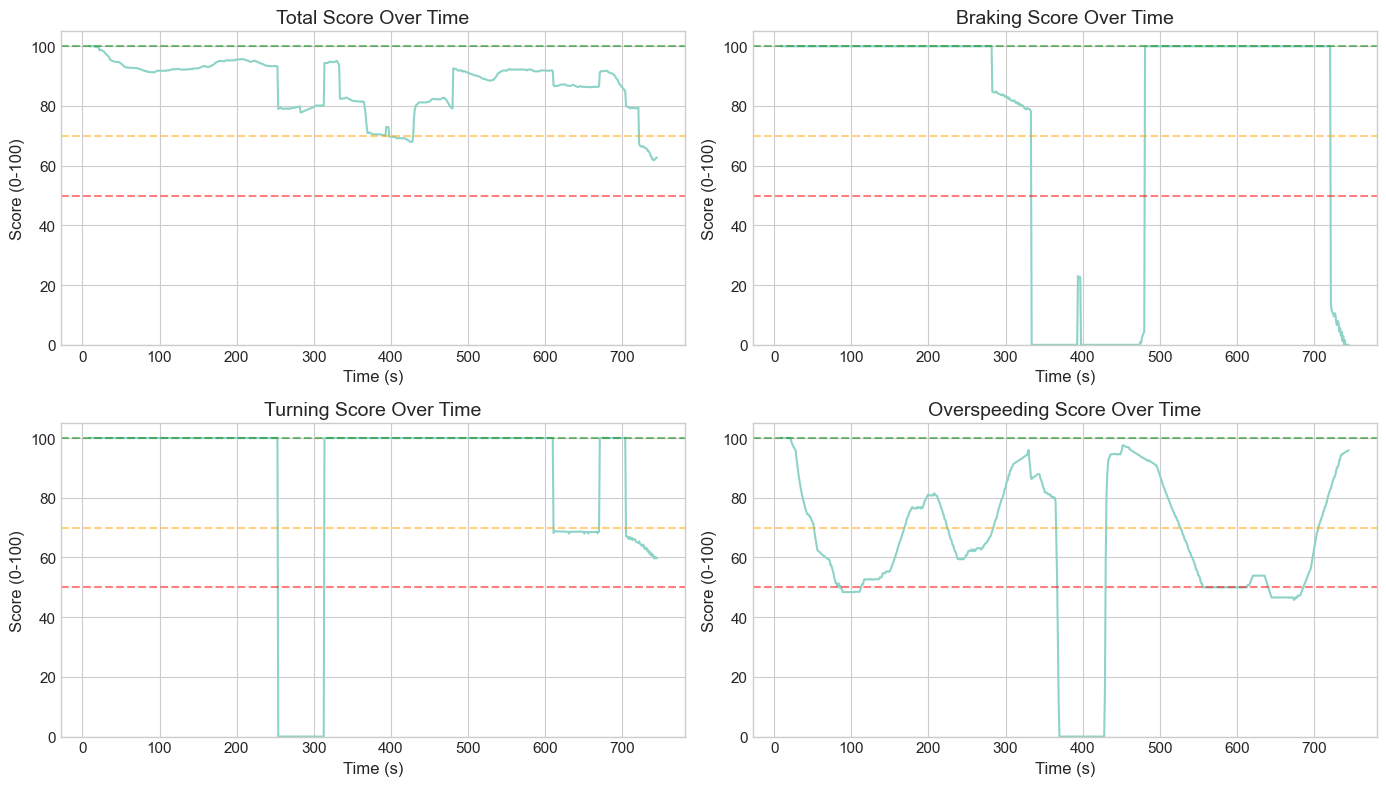

In [7]:
# Load semantic data using src function
semantic = load_semantic_online(sample_trip['path'])
if semantic is not None:
    print(f"Semantic data: {len(semantic)} rows")

    # Plot score evolution
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    score_cols = ['score_total', 'score_brake', 'score_turn', 'score_speed']
    titles = ['Total Score', 'Braking Score', 'Turning Score', 'Overspeeding Score']

    for ax, col, title in zip(axes.flatten(), score_cols, titles):
        if col in semantic.columns:
            ax.plot(semantic['timestamp'], semantic[col])
            ax.set_title(f'{title} Over Time')
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Score (0-100)')
            ax.set_ylim(0, 105)
            ax.axhline(y=100, color='green', linestyle='--', alpha=0.5, label='Perfect')
            ax.axhline(y=70, color='orange', linestyle='--', alpha=0.5, label='Warning')
            ax.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='Critical')

    plt.tight_layout()
    plt.savefig(project_root / 'results' / 'figures' / 'score_evolution.png', dpi=300, bbox_inches='tight')
    plt.show()


## 5. Feature Engineering from Raw Data

Now let's extract meaningful features from the raw sensor data using `extract_raw_features()` from src.


In [8]:
# Test on sample trip using src function
sample_features = extract_raw_features(sample_trip['path'])
print_header("EXTRACTED FEATURES", "📋")
for k, v in sample_features.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")



📋 EXTRACTED FEATURES
  speed_mean: 120.1536
  speed_std: 23.6682
  speed_max: 148.8000
  speed_min: 42.7000
  speed_change_mean: 1.1168
  speed_change_std: 1.8595
  course_change_mean: 1.7360
  course_change_std: 3.7292
  course_change_max: 47.8830
  trip_duration: 735.9700
  acc_x_mean: -0.0118
  acc_x_std: 0.0271
  acc_y_mean: -0.0006
  acc_y_std: 0.0297
  acc_magnitude_mean: 0.0414
  acc_magnitude_std: 0.0312
  acc_magnitude_max: 0.3773
  jerk_x_std: 0.0242
  jerk_y_std: 0.0130
  brake_count: 50
  hard_brake_count: 0
  accel_count: 3
  turn_count: 92
  sharp_turn_count: 0
  event_braking_count: 8
  event_braking_low: 5
  event_braking_medium: 3
  event_braking_high: 0
  event_turning_count: 3
  event_turning_low: 2
  event_turning_medium: 1
  event_turning_high: 0
  event_acceleration_count: 0
  event_acceleration_low: 0
  event_acceleration_medium: 0
  event_acceleration_high: 0


## 6. Building Dataset from All Trips

Using `build_raw_dataset()` from src to process all trips.


In [9]:
print("Building dataset from raw data using src function...")
raw_df = build_raw_dataset(trips)
print(f"Dataset shape: {raw_df.shape}")
print(f"Behaviors: {raw_df['behavior'].value_counts().to_dict()}")

# Save for reuse
raw_df.to_csv(project_root / 'data' / 'processed' / 'uah_raw_features.csv', index=False)
print_success("Raw features saved!")


Building dataset from raw data using src function...


/Users/rezami/PycharmProjects/ABAX/src/data/raw_loader.py:168: UserWarning: Error loading events from /Users/rezami/PycharmProjects/ABAX/data/UAH-DRIVESET-v1/D4/20151203173103-17km-D4-NORMAL2-SECONDARY/EVENTS_INERTIAL.txt: No columns to parse from file
  warnings.warn(f"Error loading events from {events_file}: {e}")


Dataset shape: (40, 39)
Behaviors: {'NORMAL': 17, 'DROWSY': 12, 'AGGRESSIVE': 11}
✅ Raw features saved!


## 7. Classification with Raw Features


In [10]:
# Prepare data
feature_cols = [c for c in raw_df.columns if c not in ['driver', 'behavior', 'road_type']]
X = raw_df[feature_cols].fillna(0)
y = raw_df['behavior']
groups = raw_df['driver']

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Features: {len(feature_cols)}")
print(f"Samples: {len(X)}")
print(f"Classes: {le.classes_}")


Features: 36
Samples: 40
Classes: ['AGGRESSIVE' 'DROWSY' 'NORMAL']


### 7.1 Leave-One-Driver-Out Cross-Validation

This is the most rigorous evaluation - tests how well the model generalizes to completely unseen drivers.


In [11]:
logo = LeaveOneGroupOut()

# Test multiple classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42),
}

print_header("LEAVE-ONE-DRIVER-OUT CROSS-VALIDATION", "🔬")
results = {}

for name, clf in classifiers.items():
    scores = cross_val_score(clf, X_scaled, y_enc, cv=logo, groups=groups, scoring='accuracy')
    results[name] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'scores': scores
    }
    print(f"\n{name}:")
    print(f"  Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")
    print(f"  Per-driver: {[f'{s:.2f}' for s in scores]}")



🔬 LEAVE-ONE-DRIVER-OUT CROSS-VALIDATION

Random Forest:
  Accuracy: 0.6952 ± 0.1704
  Per-driver: ['0.57', '0.86', '0.57', '1.00', '0.57', '0.60']

Gradient Boosting:
  Accuracy: 0.6619 ± 0.1847
  Per-driver: ['0.57', '0.57', '0.71', '1.00', '0.71', '0.40']


### 7.2 Feature Importance Analysis



⭐ TOP 15 MOST IMPORTANT FEATURES
             Feature  Importance
event_braking_medium    0.108041
   speed_change_mean    0.080976
  acc_magnitude_mean    0.063562
   acc_magnitude_std    0.063396
           speed_max    0.056680
         accel_count    0.049524
 event_braking_count    0.045772
          acc_x_mean    0.043412
          speed_mean    0.042046
           acc_y_std    0.033710
   acc_magnitude_max    0.033417
   event_braking_low    0.032741
          jerk_y_std    0.031309
           speed_std    0.030503
           acc_x_std    0.027907


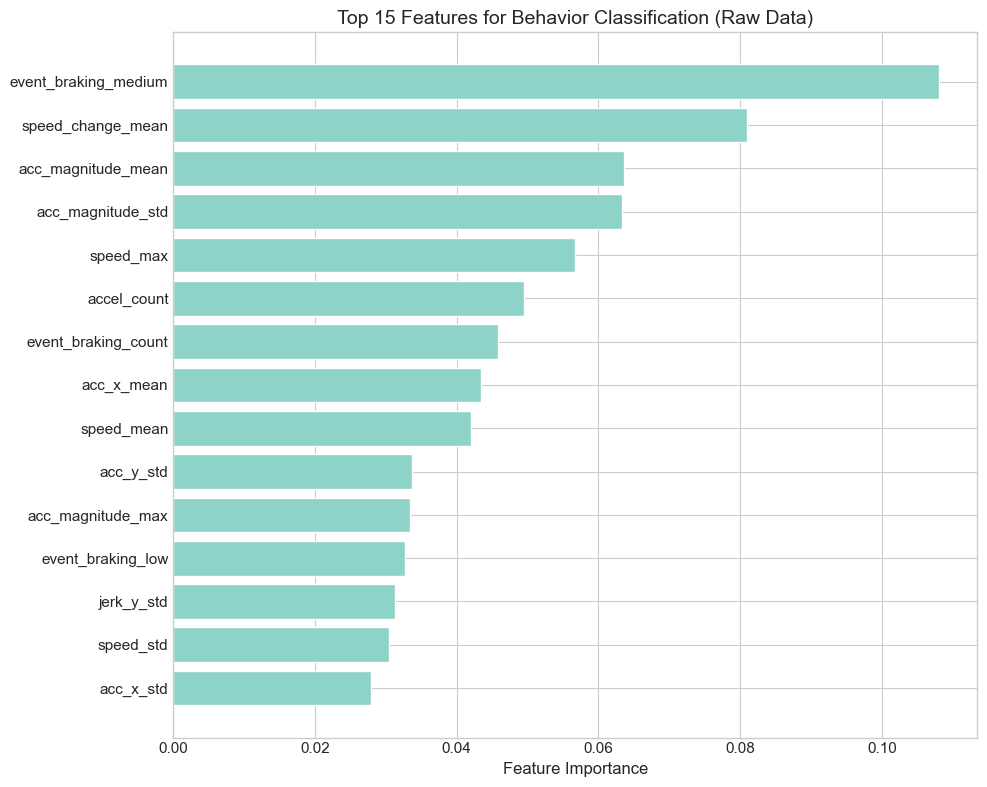

In [12]:
# Train on all data to get feature importance
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_scaled, y_enc)

# Get importance
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print_header("TOP 15 MOST IMPORTANT FEATURES", "⭐")
print(importance_df.head(15).to_string(index=False))

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
top_n = importance_df.head(15)
ax.barh(range(len(top_n)), top_n['Importance'].values, align='center')
ax.set_yticks(range(len(top_n)))
ax.set_yticklabels(top_n['Feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Feature Importance')
ax.set_title('Top 15 Features for Behavior Classification (Raw Data)')
plt.tight_layout()
plt.savefig(project_root / 'results' / 'figures' / 'raw_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


## 8. Comparing Behaviors


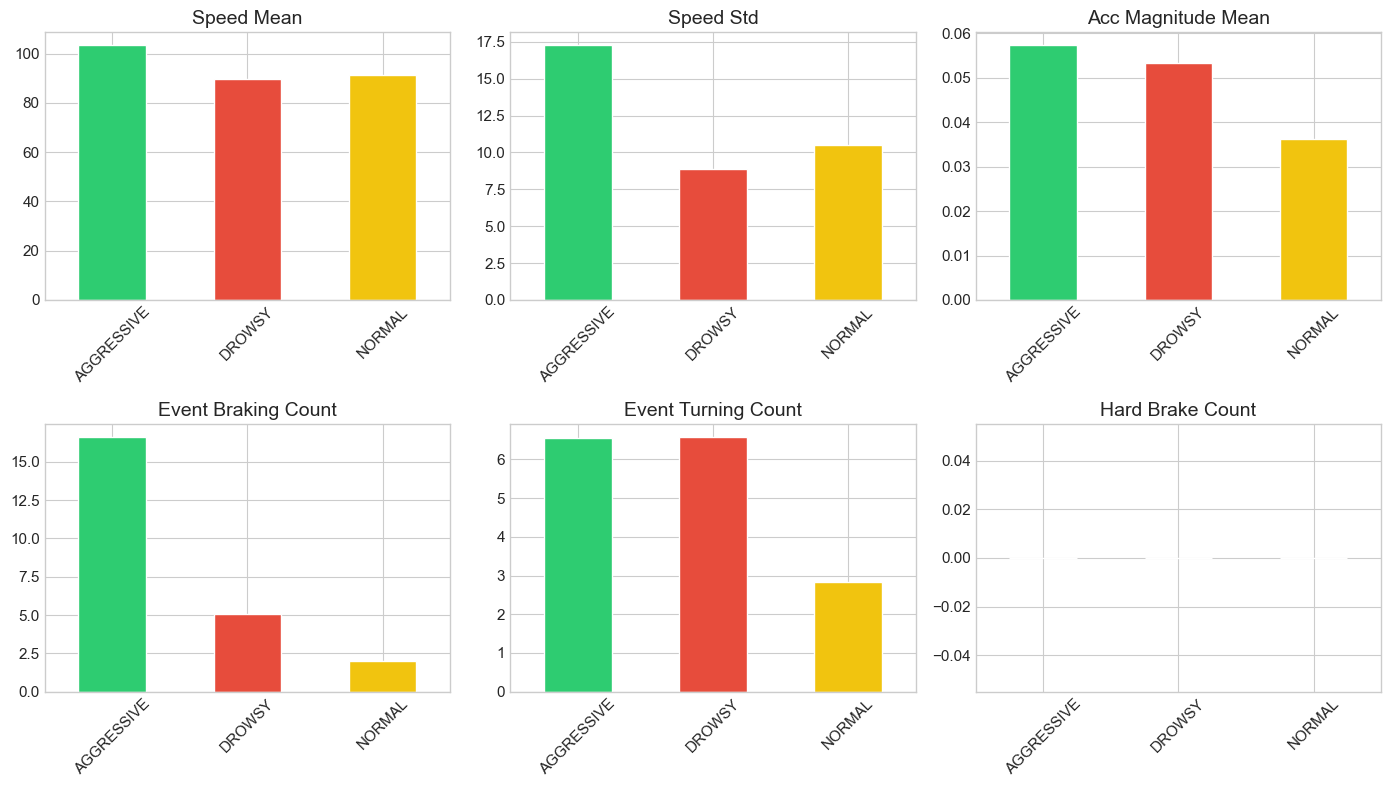

In [13]:
# Aggregate features by behavior
behavior_stats = raw_df.groupby('behavior')[feature_cols].mean()

# Select key features
key_features = ['speed_mean', 'speed_std', 'acc_magnitude_mean',
                'event_braking_count', 'event_turning_count', 'hard_brake_count']

fig, axes = plt.subplots(2, 3, figsize=(14, 8))

for ax, feat in zip(axes.flatten(), key_features):
    if feat in behavior_stats.columns:
        behavior_stats[feat].plot(kind='bar', ax=ax, color=['#2ecc71', '#e74c3c', '#f1c40f'])
        ax.set_title(feat.replace('_', ' ').title())
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(project_root / 'results' / 'figures' / 'behavior_comparison_raw.png', dpi=300, bbox_inches='tight')
plt.show()


## 9. Summary

### Key Insights

1. **Event Detection**:
   - Events (braking, turning, acceleration) are detected from accelerometer thresholds
   - X-axis (longitudinal) → braking/acceleration
   - Y-axis (lateral) → turning
   - Kalman filtering smooths the raw signal for reliable detection

2. **Scoring Algorithm**:
   - Scores start at 100 (perfect) and decrease with each event
   - High-severity events have larger penalties
   - The "Total Score" combines all individual scores

3. **Feature Engineering**:
   - Raw data provides richer features than pre-computed summaries
   - Speed variability and acceleration patterns are highly discriminative
   - Event counts (especially high-severity) are strong predictors

4. **Model Performance**:
   - Leave-One-Driver-Out CV gives realistic generalization estimates
   - Raw features can achieve comparable or better performance than pre-computed scores
   - Important features: speed stats, acceleration magnitude, event counts

### Recommendations for ABAX

1. **Use raw accelerometer data** when available for richer features
2. **Kalman filter** the signals to reduce noise
3. **Combine multiple feature types**: speed, acceleration, events
4. **Validate with driver-level splits** to ensure generalization
5. **Consider severity weighting** in event-based features

---

**✅ Raw Data Analysis Complete**
